In [136]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D

import time
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
import torch
import itertools

#from scipy.spatial.transform import Rotation as R

from tracking_utils import *

# camera intrinsics/rig extrinsics 
## (to be modified to pull live data in the future)

In [2]:
intrinsics = load_lut("data/Depth AHaT_lut.bin")
intrinsics_map = np.reshape(intrinsics, (512, 512, -1))

right_intrinsics = load_lut("data/VLC RF_lut.bin")
right_intrinsics = np.reshape(right_intrinsics, (480, 640, -1)) # correct order?
right_intrinsics = np.flip(right_intrinsics, axis=1) # need flip?
riflat = np.reshape(right_intrinsics, (-1,3))

left_intrinsics = load_lut("data/VLC LF_lut.bin")
left_intrinsics = np.reshape(left_intrinsics, (480, 640, -1)) # correct order?
left_intrinsics = np.flip(left_intrinsics, axis=0) # need flip?
liflat = np.reshape(left_intrinsics, (-1,3))

r2d = load_r2c("data/Depth AHaT_extrinsics.txt")
d2r = np.linalg.inv(r2d)
r2right = load_r2c("data/VLC RF_extrinsics.txt")
r2left = load_r2c("data/VLC LF_extrinsics.txt")
d2right = r2right.dot(d2r)
d2left = r2left.dot(d2r)

# load ellipse segmentation model

In [3]:
DEVICE = torch.device('cuda')
ellipsegnet = EllipSegNet(16, 1)
ellipsegnet.load_state_dict(torch.load('py_ellipsegnet.pt', map_location=DEVICE))
ellipsegnet.to(DEVICE)
ellipsegnet.eval()
print('loaded')

loaded


# get pose data (cam2world) for specified session

In [4]:
# time in ms
# transforms in metres
session_name = "14-01-2022-15-48-40"
#14-01-2022-12-22-15
#14-01-2022-15-48-40

depth_trans = np.reshape(np.loadtxt("data/" + session_name + "/depthextrinsics.txt", dtype=str, delimiter="\n"), (-1,5))
depth_trans = np.array([[int(row[0]), np.array("".join(row[1:]).split(",")[:-1]).astype(np.float).reshape(4,4).transpose()] for row in depth_trans])
left_trans = np.reshape(np.loadtxt("data/" + session_name + "/leftextrinsics.txt", dtype=str, delimiter="\n"), (-1,5))
left_trans = np.array([[int(row[0]), np.array("".join(row[1:]).split(",")[:-1]).astype(np.float).reshape(4,4).transpose()] for row in left_trans])
right_trans = np.reshape(np.loadtxt("data/" + session_name + "/rightextrinsics.txt", dtype=str, delimiter="\n"), (-1,5))
right_trans = np.array([[int(row[0]), np.array("".join(row[1:]).split(",")[:-1]).astype(np.float).reshape(4,4).transpose()] for row in right_trans])

# process and visualize tracked data frame by frame

In [417]:
def extract_major_tip(image, end_pxs,
                     buffer=50, threshold_type='gaussian',
                     global_params=90,
                     gaussian_params=[15,-55]):
    
    x_bounds = [np.min(end_pxs[:,0]) - buffer, np.max(end_pxs[:,0]) + buffer]
    y_bounds = [np.min(end_pxs[:,1]) - int(buffer/2), np.max(end_pxs[:,1]) + buffer]
    if y_bounds[0] < 0:
        y_bounds[0] = 0
    if x_bounds[0] < 0:
        x_bounds[0] = 0
    if y_bounds[1] > image.shape[0] - 1:
        y_bounds[1] = image.shape[0] - 1
    if x_bounds[1] > image.shape[1] - 1:
        x_bounds[1] = image.shape[1] - 1      
    print(image.shape, y_bounds, x_bounds)
    cropped = image[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]
    print(cropped.shape)

    marker_diff = [np.max(end_pxs[:,0]) - np.min(end_pxs[:,0]), 
                   np.max(end_pxs[:,1]) - np.min(end_pxs[:,1])]
    marker_length = np.sqrt((np.min(end_pxs[:,0]) - np.max(end_pxs[:,0]))**2 + 
                            (np.min(end_pxs[:,1]) - np.max(end_pxs[:,1]))**2)

    scharrx = np.absolute(cv2.Scharr(cropped[:,:,0],cv2.CV_64F,0,1))
    scharrx = np.uint8(scharrx)
    scharry = np.absolute(cv2.Scharr(cropped[:,:,0],cv2.CV_64F,1,0))
    scharry = np.uint8(scharry)
    scharr_full = scharry + scharrx    
    
    if threshold_type == 'global':
        binarized = (scharr_full > np.percentile(scharr_full, 90)).astype(np.uint8)
    elif threshold_type == 'gaussian':
        binarized = cv2.adaptiveThreshold(scharr_full.copy(), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, gaussian_params[0], gaussian_params[1])
    else:
        raise Exception("select valid type")
        
    lines = cv2.HoughLinesP(binarized, 0.25, 0.25*np.pi/180, int(marker_length/3), minLineLength=int(marker_length/3), maxLineGap=10)
    major_candidates = np.array([line for line in lines if np.sqrt(np.sum(np.diff(line.squeeze().reshape(2,2), axis=0)**2)) > marker_length])    
    angle_candidates = []
    for line in major_candidates:
        line_diff = np.diff(line.squeeze().reshape(2,2), axis=0)
        angle_diff = np.degrees(np.arccos(line_diff.dot(marker_diff)/(np.linalg.norm(line_diff)*np.linalg.norm(marker_diff))))
        #print(angle_diff)
        if angle_diff < 4.5: # degree tolerance (give some for placement, and image distortions)
            angle_candidates.append(line)
    major_candidates = np.array(angle_candidates)
    
    lines = cv2.HoughLinesP(binarized, 0.25, 0.25*np.pi/180, 5, minLineLength=5, maxLineGap=5)
    minor_candidates = np.array([line for line in lines if np.sqrt(np.sum(np.diff(line.squeeze().reshape(2,2), axis=0)**2)) < marker_length/1.5])    
    angle_candidates = []
    for line in minor_candidates:
        line_diff = np.diff(line.squeeze().reshape(2,2), axis=0)
        angle_diff = np.degrees(np.arccos(line_diff.dot(marker_diff)/(np.linalg.norm(line_diff)*np.linalg.norm(marker_diff))))
        #print(angle_diff)
        if angle_diff > 45: # higher degree tolerance (give some for placement, and image distortions)
            angle_candidates.append(line)
    minor_candidates = np.array(angle_candidates) 
    major_ends = major_candidates.squeeze().reshape((-1,2))
    distance_candidates = []
    for line in minor_candidates:
        end_points = line.squeeze().reshape(2,2) # each row is one point
        # each end point should be within n (maybe 3-4 max) pixels of at least one major candidate
        distances = cdist(end_points, major_ends)
        if np.sum(np.sum(distances < 5, axis=1) > 0) == 2:
            distance_candidates.append(line)
    minor_candidates = np.array(distance_candidates)
    
    img = image.copy()
    for line in major_candidates:
        x1,y1,x2,y2 = line[0] + [x_bounds[0], y_bounds[0], x_bounds[0], y_bounds[0]]
        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),1)    
    for line in minor_candidates:
        x1,y1,x2,y2 = line[0] + [x_bounds[0], y_bounds[0], x_bounds[0], y_bounds[0]]
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),1)                
    
    return img

In [418]:
bright_cut = [500, 0.01] # 500
d_threshold = 50 # 35cm
scales = [15, 20, 30, 40, 60, 120]
delta_threshold = [40, 500] # grab stream data with X ms of left frame

estimated_offset = 0.12 # m
roi_padding = 20 # px

processed = 0
debug_count = 0
pose = []

for idx, left_t in enumerate(left_trans[:,0]):

    closest_right_idx = np.argmin(np.abs(left_t - right_trans[:,0]))
    closest_depth_idx = np.argmin(np.abs(left_t - depth_trans[:,0]))
    if np.abs(right_trans[closest_right_idx,0] - left_t) > delta_threshold[0]:
        print('bad timings, dropping this frame')
        continue
    if np.abs(depth_trans[closest_depth_idx,0] - left_t) > delta_threshold[1]:
        print('bad timings, dropping this frame')
        continue            

    if closest_right_idx != idx:
        #print('idx mismatch: ', closest_right_idx - idx, ' debug_count: ', debug_count)
        debug_count += 1
    #continue
        
    left_image = np.flip(cv2.imread("data/" + session_name + "/left/" + str(left_t) + "_left.pgm").swapaxes(0,1), axis=1)
    right_image = np.flip(cv2.imread("data/" + session_name + "/right/" + str(right_trans[closest_right_idx,0]) + "_right.pgm").swapaxes(0,1), axis=0)
    depth_map = cv2.imread("data/" + session_name + "/depth/" + str(depth_trans[closest_depth_idx,0]) + "_depth.pgm", -1)
    bright_map = cv2.imread("data/" + session_name + "/depth/" + str(depth_trans[closest_depth_idx,0]) + "_abImage.pgm", -1)
    
    # prepare contours
    depth_map[depth_map >= 1000] = 1
    depth_map = depth_map / 1000
    far_map = (depth_map > (d_threshold/100)).astype(int)
    recon_far = (bright_map > bright_cut[0]).astype(int) * far_map
    near_map = (far_map * -1) + 1
    bright_edge = cv2.Sobel(bright_map, cv2.CV_32F, 1, 0) > 1000 #2700
    recon_near = bright_edge.astype(np.uint8)
    recon_near = cv2.dilate(recon_near, np.ones((2,2), np.uint8), iterations = 1)
    recon_near = recon_near * near_map                                                      
    border = cv2.dilate((bright_map < 100).astype(np.uint8), np.ones((7,7), np.uint8))
    recon_near = ((recon_near - border) > 0).astype(np.uint8)
    recon_full = recon_far + recon_near
    contours, _ = cv2.findContours(recon_full.astype(np.uint8), 0, method=cv2.CHAIN_APPROX_NONE)    
    cont1 = [c for c in contours if len(c) > 1]

    # process contours
    ret, imloc, locloc = candidate_search(cont1, depth_map, intrinsics_map, recon_full, 1)    
    try:
        if len(imloc) != 1:
            ret = False
    except:
        ret = False
    
    if ret:
        imloc = imloc[0]
        locloc = locloc[0]
        # get valid projections
        ret, right_pixels, left_pixels = project_onto_stereo(locloc, d2right, d2left, right_intrinsics, left_intrinsics)
    
        if ret:
        
            # do cropping
            right_image1 = right_image.copy()[:,:,0]
            left_image1 = left_image.copy()[:,:,0]      
            bounds = np.linalg.norm(left_pixels[0] - left_pixels[1]) * 0.75
            scale_select = np.argmin(np.abs(bounds-scales))
            bounds = scales[scale_select]    
            patches1 = [static_cropper(left_image1, left_pixels[i], px=bounds) for i in range(len(left_pixels))]
            patches2 = [static_cropper(right_image1, right_pixels[i], px=bounds) for i in range(len(right_pixels))]    

            # do segmentation
            patches_up1 = [cv2.resize(patches1[i], (120, 120)) for i in range(len(patches1))]
            patches_up2 = [cv2.resize(patches2[i], (120, 120)) for i in range(len(patches2))]
            patches_all = np.stack(patches_up1+patches_up2, 0)
            patches_all = torch.from_numpy(np.float32(patches_all/255)).unsqueeze(1)        
            seg_out = torch.sigmoid(ellipsegnet(patches_all.to(DEVICE)))
            seg_out = seg_out.squeeze(1).detach().cpu().numpy()
            seg_out = np.uint8(255*(seg_out>0.5))
            seg_out = [seg_out[i,:,:].squeeze() for i in range(seg_out.shape[0])]
            seg_out_down = [cv2.resize(seg_out[i], patches1[0].shape) for i in range(len(seg_out))]

            # get sub-pixel
            ret, centers = eval_contours(seg_out_down)
            if ret:
                centers += (np.vstack([left_pixels, right_pixels]) - np.array([bounds, bounds]))
                c_left = centers[:3,:]
                c_right = centers[3:,:]

                # get subpixel-accuracy vectors in worldspace (1ms)           
                right2w = right_trans[closest_right_idx][1].copy()
                left2w = left_trans[idx][1].copy()
                oleft, oright, leftpts, rightpts = recover_rays(c_left, c_right, left_intrinsics, right_intrinsics, left2w, right2w)
                ret, end_left, end_right = intersect_solver(oleft, oright, leftpts, rightpts, 0.0012)
    if ret:
        leftcam_pts = np.linalg.inv(left2w).dot(np.hstack((end_left, np.ones(3).transpose()[:,None])).transpose()).transpose()[:,:-1]
        rightcam_pts = np.linalg.inv(right2w).dot(np.hstack((end_right, np.ones(3).transpose()[:,None])).transpose()).transpose()[:,:-1]
        
        leftend_pts = leftcam_pts[[0,1], :] + ((leftcam_pts[2,:] - leftcam_pts[0,:]) * (estimated_offset/np.linalg.norm(leftcam_pts[2,:] - leftcam_pts[0,:])))
        rightend_pts = rightcam_pts[[0,1], :] + ((rightcam_pts[2,:] - rightcam_pts[0,:]) * (estimated_offset/np.linalg.norm(rightcam_pts[2,:] - rightcam_pts[0,:])))
        leftend_pxs = search_intrinsics(leftend_pts / np.linalg.norm(leftend_pts, axis=1)[:,None], left_intrinsics)
        rightend_pxs = search_intrinsics(rightend_pts / np.linalg.norm(rightend_pts, axis=1)[:,None], right_intrinsics)
        processed += 1
        pose.append([end_left, end_right])
    
    
    ############################## VIS ##############################
        
    # get 3 axis of each camera, plot together
    # yz flipped for vis, x negatived for vis

    left_image1 = left_image.copy()
    right_image1 = right_image.copy()
    if ret:
        cv2.line(right_image1, (right_pixels[0,0], right_pixels[0,1]), (right_pixels[1,0], right_pixels[1,1]), (0,0,255), 2)
        cv2.line(right_image1, (right_pixels[0,0], right_pixels[0,1]), (right_pixels[2,0], right_pixels[2,1]), (0,0,255), 2)
        cv2.line(left_image1, (left_pixels[0,0], left_pixels[0,1]), (left_pixels[1,0], left_pixels[1,1]), (0,0,255), 2)
        cv2.line(left_image1, (left_pixels[0,0], left_pixels[0,1]), (left_pixels[2,0], left_pixels[2,1]), (0,0,255), 2)    
        
        cv2.line(right_image1, (c_right[0,0].astype(int), c_right[0,1].astype(int)), (c_right[1,0].astype(int), c_right[1,1].astype(int)), (0,255,0), 2)
        cv2.line(right_image1, (c_right[0,0].astype(int), c_right[0,1].astype(int)), (c_right[2,0].astype(int), c_right[2,1].astype(int)), (0,255,0), 2)
        cv2.line(left_image1, (c_left[0,0].astype(int), c_left[0,1].astype(int)), (c_left[1,0].astype(int), c_left[1,1].astype(int)), (0,255,0), 2)
        cv2.line(left_image1, (c_left[0,0].astype(int), c_left[0,1].astype(int)), (c_left[2,0].astype(int), c_left[2,1].astype(int)), (0,255,0), 2)        
        
        #cv2.line(left_image1, (leftend_pxs[0,0].astype(int), leftend_pxs[0,1].astype(int)), (leftend_pxs[1,0].astype(int), leftend_pxs[1,1].astype(int)), (255,0,0), 2)        
        #cv2.line(right_image1, (rightend_pxs[0,0].astype(int), rightend_pxs[0,1].astype(int)), (rightend_pxs[1,0].astype(int), rightend_pxs[1,1].astype(int)), (255,0,0), 2)        
    
        left_image1 = extract_major_tip(left_image1.copy(), leftend_pxs)
        right_image1 = extract_major_tip(right_image1.copy(), rightend_pxs)
        
    stereo_image = np.hstack((left_image1, right_image1))
    
    print(ret, idx)#, end='\r')
    cv2.imshow("stereo1", stereo_image)
    cv2.setWindowTitle('stereo1', str(idx))
    key = cv2.waitKey(100)
    if key == ord('q'):
        break  
    
    if idx >= 300 and ret:
        print('exiting at: ', idx)
        break
    
print(processed, ' / ', len(left_trans[:,0]))
print('recording time: ', (left_trans[-1,0] - left_trans[0,0])/1000)
cv2.destroyAllWindows()
plt.close()

bad timings, dropping this frame
(640, 480, 3) [451, 526] [263, 397]
(75, 134, 3)
(640, 480, 3) [445, 521] [112, 246]
(76, 134, 3)
True 1
(640, 480, 3) [448, 523] [265, 399]
(75, 134, 3)
(640, 480, 3) [443, 519] [113, 248]
(76, 135, 3)
True 2
(640, 480, 3) [450, 526] [266, 400]
(76, 134, 3)
(640, 480, 3) [446, 521] [111, 246]
(75, 135, 3)
True 3
(640, 480, 3) [451, 526] [263, 398]
(75, 135, 3)
(640, 480, 3) [445, 521] [111, 246]
(76, 135, 3)
True 4
(640, 480, 3) [452, 527] [258, 393]
(75, 135, 3)
(640, 480, 3) [446, 521] [107, 243]
(75, 136, 3)
True 5
(640, 480, 3) [455, 530] [253, 387]
(75, 134, 3)
(640, 480, 3) [451, 526] [101, 236]
(75, 135, 3)
True 6
(640, 480, 3) [458, 533] [255, 390]
(75, 135, 3)
(640, 480, 3) [454, 529] [101, 236]
(75, 135, 3)
True 7
(640, 480, 3) [452, 528] [266, 400]
(76, 134, 3)
(640, 480, 3) [448, 523] [113, 248]
(75, 135, 3)
True 8
(640, 480, 3) [449, 524] [266, 400]
(75, 134, 3)
(640, 480, 3) [446, 521] [113, 248]
(75, 135, 3)
True 9
(640, 480, 3) [450, 52

<ipython-input-417-33681b1fe09b>:54: RuntimeWarning: invalid value encountered in arccos
  angle_diff = np.degrees(np.arccos(line_diff.dot(marker_diff)/(np.linalg.norm(line_diff)*np.linalg.norm(marker_diff))))
<ipython-input-417-33681b1fe09b>:56: RuntimeWarning: invalid value encountered in greater
  if angle_diff > 45: # higher degree tolerance (give some for placement, and image distortions)


(640, 480, 3) [463, 546] [133, 278]
(83, 145, 3)
True 55
(640, 480, 3) [467, 550] 

<ipython-input-417-33681b1fe09b>:54: RuntimeWarning: invalid value encountered in arccos
  angle_diff = np.degrees(np.arccos(line_diff.dot(marker_diff)/(np.linalg.norm(line_diff)*np.linalg.norm(marker_diff))))
<ipython-input-417-33681b1fe09b>:56: RuntimeWarning: invalid value encountered in greater
  if angle_diff > 45: # higher degree tolerance (give some for placement, and image distortions)


[336, 476]
(83, 140, 3)
(640, 480, 3) [462, 545] [131, 277]
(83, 146, 3)
True 56
(640, 480, 3) [467, 551] [335, 475]
(84, 140, 3)
(640, 480, 3) [464, 547] [129, 275]
(83, 146, 3)
True 57
(640, 480, 3) [474, 557] [336, 476]
(83, 140, 3)


<ipython-input-417-33681b1fe09b>:54: RuntimeWarning: invalid value encountered in arccos
  angle_diff = np.degrees(np.arccos(line_diff.dot(marker_diff)/(np.linalg.norm(line_diff)*np.linalg.norm(marker_diff))))
<ipython-input-417-33681b1fe09b>:56: RuntimeWarning: invalid value encountered in greater
  if angle_diff > 45: # higher degree tolerance (give some for placement, and image distortions)


(640, 480, 3) [472, 556] [131, 277]
(84, 146, 3)
True 58
(640, 480, 3) [480, 565] [342, 479]
(85, 137, 3)
(640, 480, 3) [477, 562] [135, 281]
(85, 146, 3)
True 59
(640, 480, 3) [489, 574] [351, 479]
(85, 128, 3)
(640, 480, 3) [485, 570] [141, 287]
(85, 146, 3)
True 60
(640, 480, 3) [491, 576] [355, 479]
(85, 124, 3)
(640, 480, 3) [485, 570] [140, 287]
(85, 147, 3)
True 61
(640, 480, 3) [491, 577] [355, 479]
(86, 124, 3)
(640, 480, 3) [484, 570] [137, 285]
(86, 148, 3)
True 62
(640, 480, 3) [487, 572] [351, 479]
(85, 128, 3)
(640, 480, 3) [480, 566] [133, 281]
(86, 148, 3)
True 63
(640, 480, 3) [485, 572] [350, 479]
(87, 129, 3)
(640, 480, 3) [478, 565] [131, 278]
(87, 147, 3)
True 64
False 65
(640, 480, 3) [479, 566] [345, 479]
(87, 134, 3)
(640, 480, 3) [472, 559] [128, 275]
(87, 147, 3)
True 66
False 67
(640, 480, 3) [476, 563] [347, 479]
(87, 132, 3)
(640, 480, 3) [470, 557] [132, 279]
(87, 147, 3)
True 68
False 69
False 70
False 71
False 72
False 73
False 74
border detected, invali

<ipython-input-417-33681b1fe09b>:54: RuntimeWarning: invalid value encountered in arccos
  angle_diff = np.degrees(np.arccos(line_diff.dot(marker_diff)/(np.linalg.norm(line_diff)*np.linalg.norm(marker_diff))))
<ipython-input-417-33681b1fe09b>:56: RuntimeWarning: invalid value encountered in greater
  if angle_diff > 45: # higher degree tolerance (give some for placement, and image distortions)


False 127
(640, 480, 3) [478, 559] [373, 479]
(81, 106, 3)
(640, 480, 3) [474, 555] [138, 291]
(81, 153, 3)
True 128
(640, 480, 3) [483, 563] [370, 479]
(80, 109, 3)
(640, 480, 3) [479, 559] [135, 288]
(80, 153, 3)
True 129
(640, 480, 3) [487, 567] [369, 479]
(80, 110, 3)
(640, 480, 3) [481, 561] [135, 288]
(80, 153, 3)
True 130
(640, 480, 3) [490, 570] [371, 479]
(80, 108, 3)
(640, 480, 3) [485, 566] [136, 290]
(81, 154, 3)
True 131
False 132
(640, 480, 3) [495, 574] [376, 479]
(79, 103, 3)
(640, 480, 3) [490, 569] [136, 291]
(79, 155, 3)
True 133
(640, 480, 3) [497, 575] [376, 479]
(78, 103, 3)
(640, 480, 3) [489, 568] [137, 291]
(79, 154, 3)
True 134
(640, 480, 3) [500, 578] [374, 479]
(78, 105, 3)
(640, 480, 3) [494, 572] [128, 283]
(78, 155, 3)
True 135
False 136
(640, 480, 3) [502, 580] [358, 479]
(78, 121, 3)
(640, 480, 3) [497, 575] [109, 266]
(78, 157, 3)
True 137
(640, 480, 3) [507, 583] [352, 479]
(76, 127, 3)
(640, 480, 3) [502, 580] [103, 260]
(78, 157, 3)
True 138
(640, 4

<ipython-input-417-33681b1fe09b>:54: RuntimeWarning: invalid value encountered in arccos
  angle_diff = np.degrees(np.arccos(line_diff.dot(marker_diff)/(np.linalg.norm(line_diff)*np.linalg.norm(marker_diff))))
<ipython-input-417-33681b1fe09b>:56: RuntimeWarning: invalid value encountered in greater
  if angle_diff > 45: # higher degree tolerance (give some for placement, and image distortions)


(640, 480, 3) [431, 523] [272, 422]
(92, 150, 3)
(640, 480, 3) [426, 517] [64, 203]
(91, 139, 3)
True 179
(640, 480, 3) [429, 520] [252, 399]
(91, 147, 3)
(640, 480, 3) [422, 513] [46, 183]
(91, 137, 3)
True 180
(640, 480, 3) [426, 517] [232, 377]
(91, 145, 3)
(640, 480, 3) [420, 512] [30, 166]
(92, 136, 3)
True 181
(640, 480, 3) [420, 511] [217, 361]
(91, 144, 3)
(640, 480, 3) [414, 504] [18, 155]
(90, 137, 3)
True 182
(640, 480, 3) [416, 507] [207, 350]
(91, 143, 3)
(640, 480, 3) [408, 499] [12, 148]
(91, 136, 3)
True 183
(640, 480, 3) [411, 502] [202, 345]
(91, 143, 3)
(640, 480, 3) [409, 500] [11, 147]
(91, 136, 3)
True 184
(640, 480, 3) [408, 499] [202, 345]
(91, 143, 3)
(640, 480, 3) [405, 496] [16, 150]
(91, 134, 3)
True 185
failed area test
False 186
(640, 480, 3) [409, 501] [213, 355]
(92, 142, 3)
(640, 480, 3) [406, 497] [28, 163]
(91, 135, 3)
True 187
(640, 480, 3) [406, 500] [222, 363]
(94, 141, 3)
(640, 480, 3) [403, 496] [32, 165]
(93, 133, 3)
True 188
(640, 480, 3) [408,

<ipython-input-417-33681b1fe09b>:54: RuntimeWarning: invalid value encountered in arccos
  angle_diff = np.degrees(np.arccos(line_diff.dot(marker_diff)/(np.linalg.norm(line_diff)*np.linalg.norm(marker_diff))))
<ipython-input-417-33681b1fe09b>:56: RuntimeWarning: invalid value encountered in greater
  if angle_diff > 45: # higher degree tolerance (give some for placement, and image distortions)


(640, 480, 3) [495, 576] [176, 330]
(81, 154, 3)
True 223
(640, 480, 3) [495, 576] [415, 479]
(81, 64, 3)
(640, 480, 3) [494, 575] [176, 330]
(81, 154, 3)
True 224
(640, 480, 3) [493, 573] [411, 479]
(80, 68, 3)
(640, 480, 3) [491, 572] [176, 330]
(81, 154, 3)
True 225
(640, 480, 3) [492, 572] [408, 479]
(80, 71, 3)
(640, 480, 3) [489, 567] [171, 324]
(78, 153, 3)
True 226
(640, 480, 3) [488, 567] [404, 479]
(79, 75, 3)
(640, 480, 3) [483, 561] [172, 325]
(78, 153, 3)
True 227
(640, 480, 3) [483, 561] [404, 479]
(78, 75, 3)


<ipython-input-417-33681b1fe09b>:54: RuntimeWarning: invalid value encountered in arccos
  angle_diff = np.degrees(np.arccos(line_diff.dot(marker_diff)/(np.linalg.norm(line_diff)*np.linalg.norm(marker_diff))))
<ipython-input-417-33681b1fe09b>:56: RuntimeWarning: invalid value encountered in greater
  if angle_diff > 45: # higher degree tolerance (give some for placement, and image distortions)


(640, 480, 3) [477, 555] [177, 329]
(78, 152, 3)
True 228
(640, 480, 3) [478, 558] [410, 479]
(80, 69, 3)
(640, 480, 3) [473, 551] [186, 338]
(78, 152, 3)
True 229
(640, 480, 3) [468, 550] [419, 479]
(82, 60, 3)
(640, 480, 3) [464, 542] [193, 345]
(78, 152, 3)
True 230
(640, 480, 3) [462, 543] [424, 479]
(81, 55, 3)
(640, 480, 3) [460, 539] [200, 352]
(79, 152, 3)
True 231
(640, 480, 3) [458, 541] [428, 479]
(83, 51, 3)
(640, 480, 3) [456, 534] [208, 359]
(78, 151, 3)
True 232
(640, 480, 3) [452, 535] [428, 479]
(83, 51, 3)
(640, 480, 3) [452, 529] [211, 361]
(77, 150, 3)
True 233
(640, 480, 3) [445, 528] [428, 479]
(83, 51, 3)
(640, 480, 3) [444, 521] [208, 358]
(77, 150, 3)
True 234
(640, 480, 3) [426, 508] [428, 479]
(82, 51, 3)
(640, 480, 3) [423, 499] [200, 351]
(76, 151, 3)
True 235
bad stereo
False 236
(640, 480, 3) [411, 490] [409, 479]
(79, 70, 3)
(640, 480, 3) [407, 482] [179, 330]
(75, 151, 3)
True 237
(640, 480, 3) [408, 486] [397, 479]
(78, 82, 3)
(640, 480, 3) [403, 479] 

In [395]:
leftend_pxs, np.diff(leftend_pxs, axis=0)

(array([[349, 413],
        [309, 415]], dtype=int64),
 array([[-40,   2]], dtype=int64))

In [406]:
test = np.random.randint(0,10,(14,1,4))
print(test.shape)
print(test[:5,:,:])

(14, 1, 4)
[[[5 7 7 5]]

 [[2 3 2 5]]

 [[0 1 2 3]]

 [[9 7 2 7]]

 [[6 8 8 7]]]


In [407]:
test2 = test.squeeze().reshape((-1,2))
print(test2.shape)
print(test2[:10,:])

(28, 2)
[[5 7]
 [7 5]
 [2 3]
 [2 5]
 [0 1]
 [2 3]
 [9 7]
 [2 7]
 [6 8]
 [8 7]]


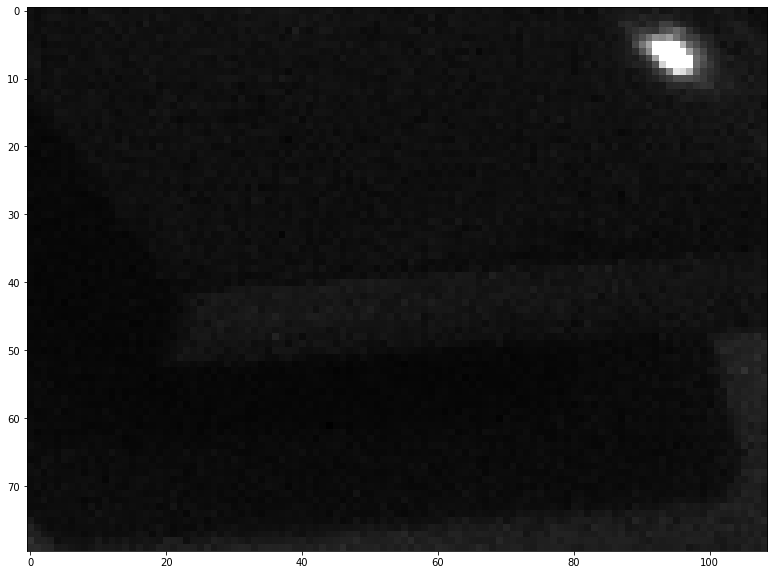

In [345]:
extract_major_tip(left_image.copy(), leftend_pxs)

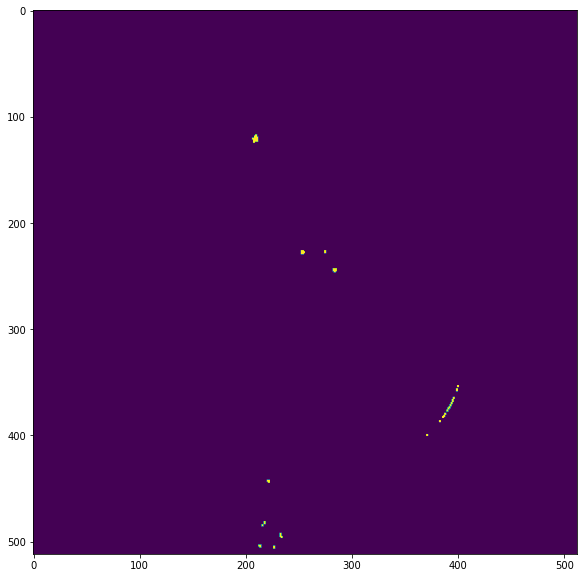

In [382]:
plt.imshow(recon_full)

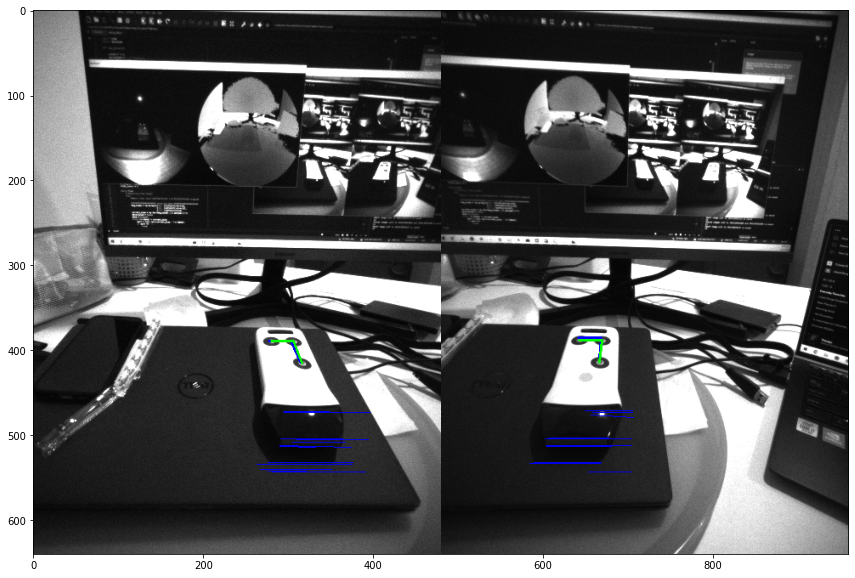

In [366]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(stereo_image)

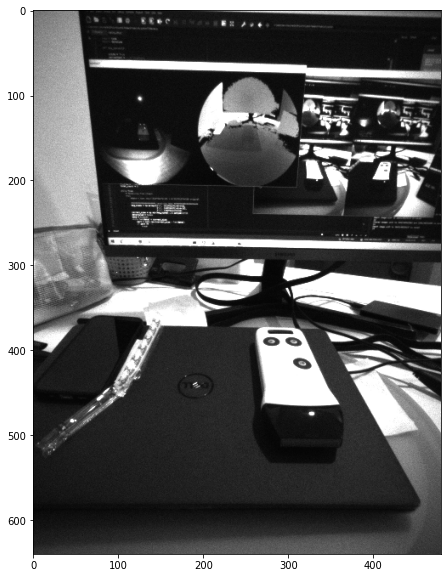

In [367]:
plt.imshow(left_image)

0.757


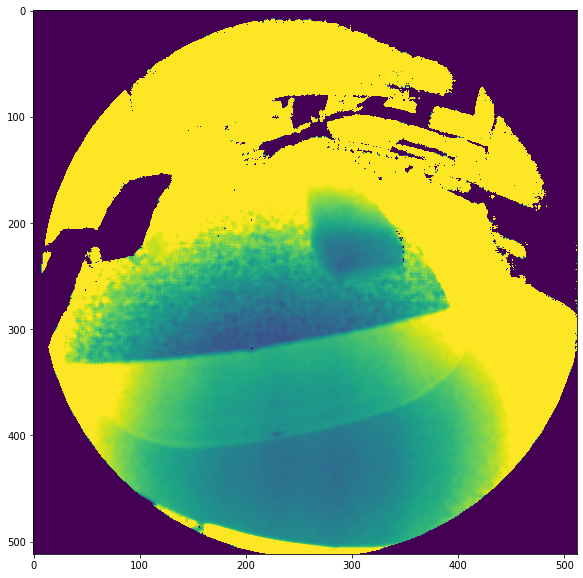

In [177]:
plt.imshow(depth_map, vmin=0.15, vmax=0.25)
print(np.max(depth_map))